In [27]:
import numpy as np
import matplotlib.pyplot as plt
from pytictoc import TicToc

In [3]:
import numpy as np
import scipy as scipy
from scipy.linalg import toeplitz
from scipy.sparse import csr_matrix, kron
def blur(N, band=3, sigma=0.7):
    z = np.block([np.exp(-(np.array([range(band)])**2)/(2*sigma**2)), np.zeros((1, N-band))])
    A = toeplitz(z)
    A = csr_matrix(A)
    A = (1/(2*scipy.pi*sigma**2))*kron(A,A)

    x = np.zeros((N, N))
    N2 = round(N/2)
    N3 = round(N/3)
    N6 = round(N/6)
    N12 = round(N/12)

    # Large elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 1:
                T[i-1,j-1] = 1

    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[2:2+2*N6, N3-1:3*N3-1] =  T

    # Small elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 0.6:
                T[i-1,j-1] = 1

    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[N6:3*N6, N3-1:3*N3-1] =  x[N6:3*N6, N3-1:3*N3-1] + 2*T
    x[x==3] = 2*np.ones((x[x==3]).shape)

    T = np.triu(np.ones((N3,N3)))
    mT, nT = T.shape
    x[N3+N12:N3+N12+nT,1:mT+1] = 3*T

    T = np.zeros((2*N6+1,2*N6+1))
    mT, nT = T.shape
    T[N6,:] = np.ones((1,nT))
    T[:,N6] = np.ones((mT))
    x[N2+N12:N2+N12+mT,N2:N2+nT] = 4*T

    x = x[:N,:N].reshape(N**2,1)
    b = A @ x

    return A, b, x

In [39]:
def generic_grad(f,gf,lsearch,x0,iterations):
    print(f'{iterations} iterations')
    clock = TicToc()
    clock.tic()
    fs = [f(x0)]
    ts = [0]
    xk = x0
    x = [x0]
    cnt = 0
    while cnt<iterations:
        gk = gf(xk)
        tk = lsearch(f,xk,gk)
        x.append(x[cnt] - tk*gk)
        # xk = xk - tk*gk
        fs.append(f(x[cnt+1]))
        ts.append(clock.tocvalue())
        cnt+=1
    return x[cnt], fs, ts

def exact_quad(A):
    return lambda f, xk, gk: (np.linalg.norm(gk) / 2*np.linalg.norm(A @ gk))**2

def const_step(s):
    return lambda f, xk,gk: s

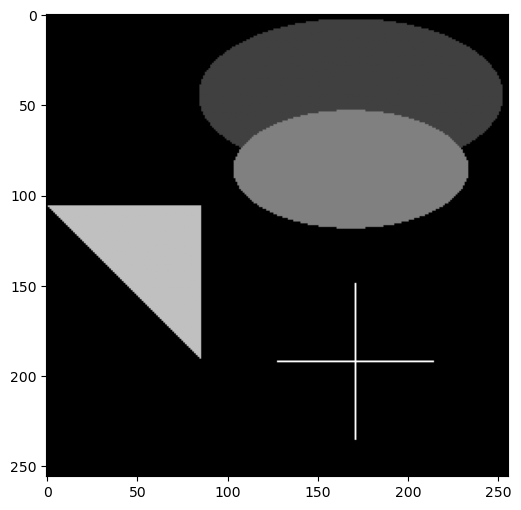

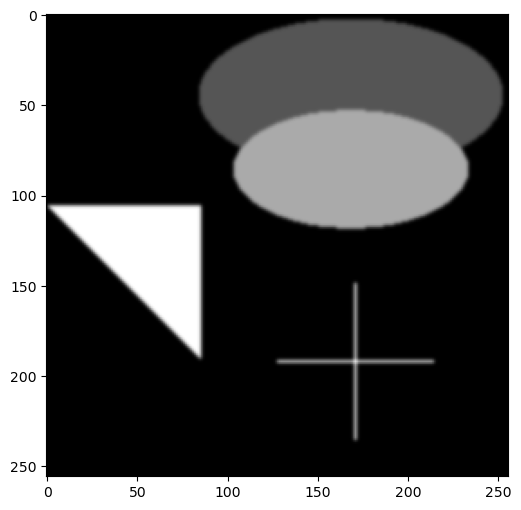

In [5]:
A, b , x = blur(256 , 5 , 1 )
plt.figure(figsize = (6,6))
plt.imshow(x.reshape(256,256),cmap='gray')
plt.show()
plt.figure(figsize=(6 ,6 ))
plt.imshow(b.reshape(256,256), cmap='gray')
plt.show()

In [6]:
A.shape

(65536, 65536)

In [7]:
f = lambda x: (np.linalg.norm(A.dot(x) - b))**2
gf = lambda x: 2*((A.T@A.dot(x)) - A.dot(b))

1 iterations


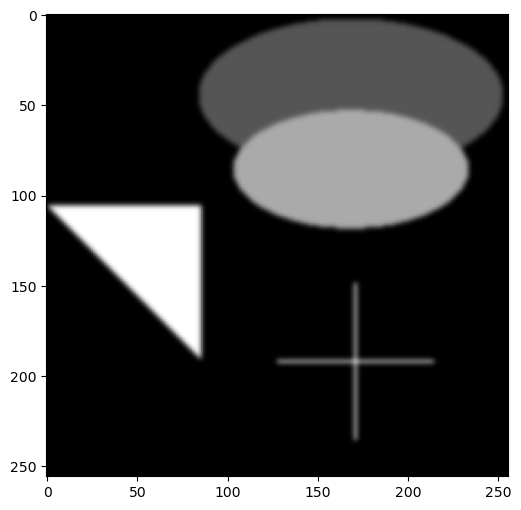

10 iterations


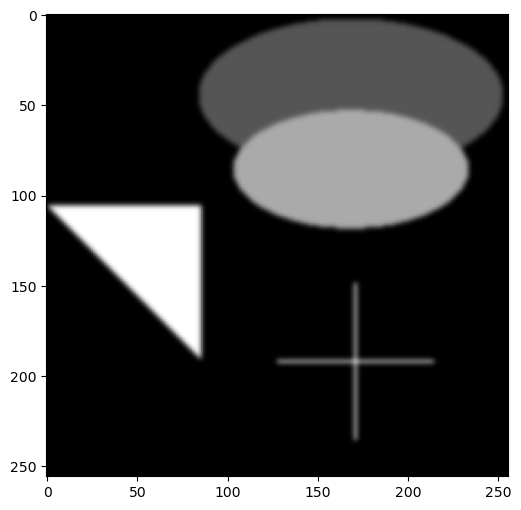

100 iterations


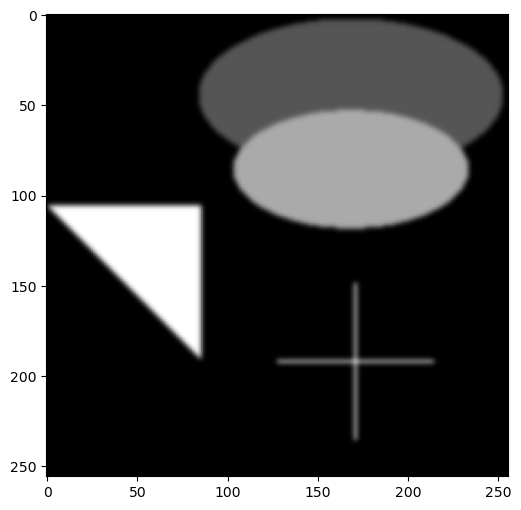

1000 iterations


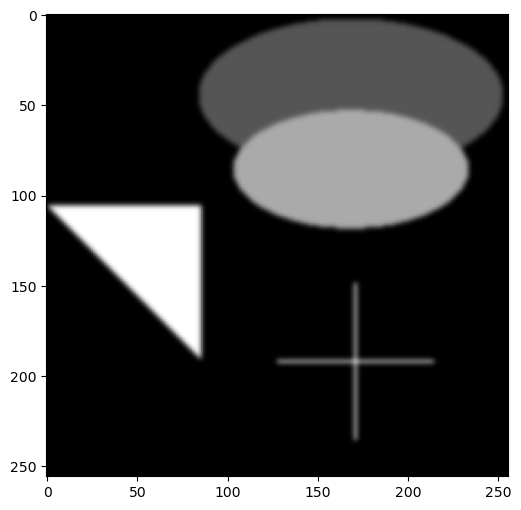

In [43]:
for i in [1,10,100,1000]:
    x_exact,fs_exact, ts_exact = generic_grad(f,gf,exact_quad(A),np.zeros(b.shape), i)
    plt.figure(figsize=(6 ,6 ))
    plt.imshow(x_exact.reshape(256,256), cmap='gray')
    plt.show()

In [18]:
B = (A.T).dot(A)

In [28]:
import scipy.sparse.linalg as linalg
L = 2*np.real(max(linalg.eigs(B)[0]))

1 iterations


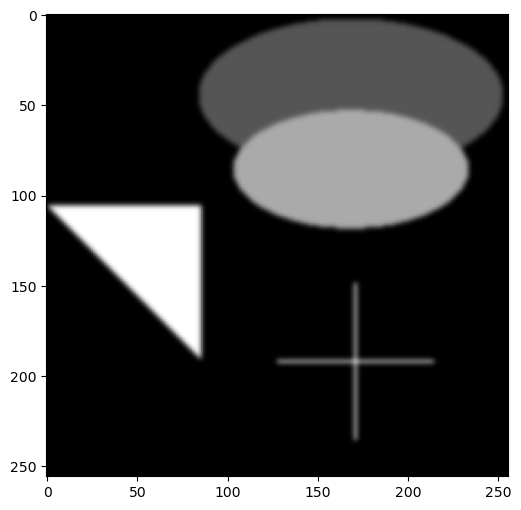

10 iterations


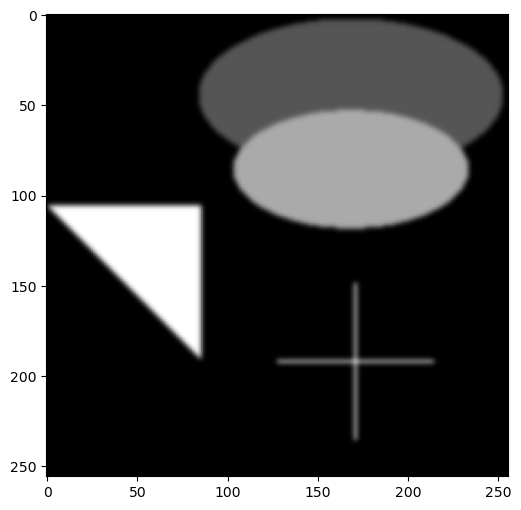

100 iterations


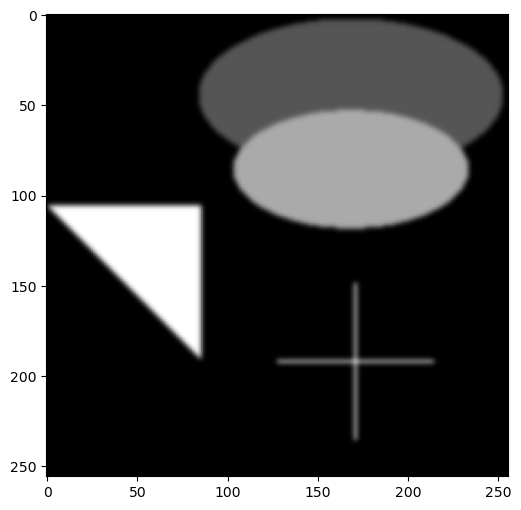

1000 iterations


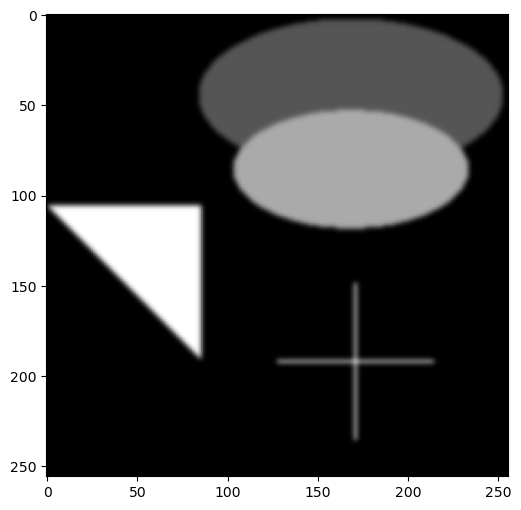

In [44]:
for i in [1,10,100,1000]:
    x_const,fs_const, ts_const = generic_grad(f,gf,const_step(1/L),np.zeros(b.shape), i)
    plt.figure(figsize=(6 ,6 ))
    plt.imshow(x_const.reshape(256,256), cmap='gray')
    plt.show()

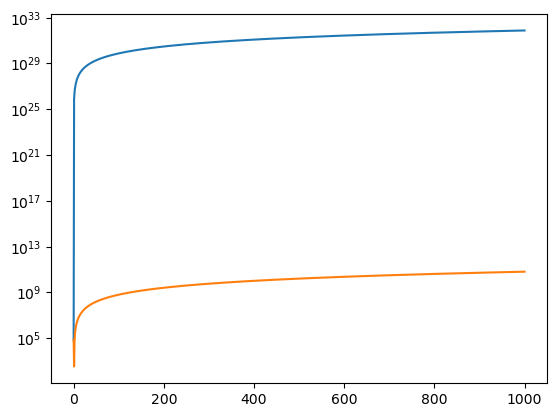

In [45]:
plt.semilogy(np.arange(len(fs_exact)),fs_exact, label='Exact line-search')
plt.semilogy(np.arange(len(fs_const)),fs_const, label='Constant step')